In [7]:
import sys
import os
import json
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.parse_lipid import parse_lipid

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm, ListedColormap
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
sns.set_style('white')

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

In [9]:
tgs = data.loc[(data['molec_class'] == 'TG')].copy()
tgs['fa_carbons'] = tgs.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[2])
tgs['fa_unsat'] = tgs.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[3])
tgs['fa_carbon:unsat'] = tgs.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[4])

min_unsats, max_unsats = min(tgs['fa_unsat']), max(tgs['fa_unsat'])
unsat_palette = sns.color_palette('Blues', n_colors=max_unsats+1)
unsat_map = {x: color for x, color in zip(range(min_unsats, max_unsats+1), unsat_palette)}
tgs['unsat_colors'] = tgs['fa_unsat'].map(unsat_map)
min_carbons, max_carbons = min(tgs['fa_carbons']), max(tgs['fa_carbons'])
carbons_palette = sns.color_palette('Greens', n_colors=(max_carbons-min_carbons+1))
carbons_cmap = {x: color for x, color in zip(range(min_carbons, max_carbons+1), carbons_palette)}
tgs['carbons_colors'] = tgs['fa_carbons'].map(carbons_cmap)
tgs = tgs.loc[:, ~tgs.columns.isin(data.columns)]
tgs

,fa_carbons,fa_unsat,fa_carbon:unsat,unsat_colors,carbons_colors
i,,,,,
l_525,64,17,64:17,"(0.03137254901960784, 0.2897347174163783, 0.57...","(0.009150326797385616, 0.43529411764705883, 0...."
l_538,66,18,66:18,"(0.03137254901960784, 0.23695501730103807, 0.4...","(0.0, 0.3221530180699732, 0.12888888888888894)"
l_546,58,12,58:12,"(0.23192618223760095, 0.5456516724336793, 0.76...","(0.30745098039215685, 0.6963475586312956, 0.39..."
l_559,60,13,60:13,"(0.1791464821222607, 0.49287197231833907, 0.73...","(0.20092272202998845, 0.6130103806228373, 0.32..."
l_567,62,14,62:14,"(0.1271049596309112, 0.4401845444059977, 0.707...","(0.11249519415609383, 0.5238754325259515, 0.25..."
...,...,...,...,...,...
l_861,57,2,57:2,"(0.8525028835063437, 0.909511726259131, 0.9625...","(0.3827450980392157, 0.7332564398308343, 0.427..."
l_863,56,1,56:1,"(0.8917339484813533, 0.9351018838908112, 0.975...","(0.45176470588235296, 0.7670895809304115, 0.46..."
l_864,60,3,60:3,"(0.8141176470588235, 0.883921568627451, 0.9498...","(0.20092272202998845, 0.6130103806228373, 0.32..."


In [10]:
cm_data = data.loc[data['molec_class'] == 'TG', fg.index].T
cm_data = cm_data.join(fg[['animal', 'bg_type']])
cm_data = cm_data.groupby(['animal', 'bg_type']).mean()
cm_data = cm_data.reset_index()
# Normalize the data to the average of the lipid across all fasted samples 
fbg_tgs_means = data.loc[data['molec_class'] == 'TG', fbg_cols].mean(axis=1)
cm_data.loc[:, tgs.index] = cm_data.loc[:, tgs.index] - fbg_tgs_means

# Sort into correct order and add metadata for column colors 
# file_order = fg.sort_values(['bg_type', 'ogtt', 'week'], ascending=[True, True, True])
cm_data = cm_data.join(ap['OGTT (AUC)'], on='animal')
cm_data = cm_data.sort_values(['bg_type', 'OGTT (AUC)'])
# Make the animal to viridis colormap by OGTT
ogtt_ordered = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].sort_values()
viridis = sns.color_palette('viridis', 10)
animal_cmap = {animal: color for animal, color in zip(ogtt_ordered.index, viridis)}
cm_data['animal_color'] = cm_data['animal'].map(animal_cmap)
cm_data

,animal,bg_type,l_525,l_538,l_546,l_559,l_567,l_569,l_573,l_579,...,l_849,l_851,l_856,l_861,l_863,l_864,l_866,l_868,OGTT (AUC),animal_color
10,1091,FBG,-0.406251,-0.867601,0.276743,-0.306780,-0.556632,-0.669636,0.700931,-0.576595,...,-0.461502,-0.081870,-0.561232,-0.391693,-0.012287,-0.035453,0.090649,-0.156400,19060.0,"(0.283072, 0.130895, 0.449241)"
14,1093,FBG,-0.422549,-0.975417,0.409137,0.017472,-0.407374,-0.179774,1.029107,-0.871545,...,0.747874,0.127719,1.319970,1.147236,1.317962,0.842524,1.165836,0.468831,25057.5,"(0.262138, 0.242286, 0.520837)"
12,1092,FBG,-0.153053,-0.843784,0.700060,0.104984,-0.564725,-0.038047,1.300992,-0.920439,...,-0.885886,-0.701583,-0.810421,-0.646904,-0.838443,-0.766115,-1.938465,-0.415276,34022.5,"(0.220057, 0.343307, 0.549413)"
4,1074,FBG,-0.545189,-0.561399,-0.248538,-0.507748,-0.217644,-0.496684,-0.432127,-0.430258,...,0.632058,-0.312727,0.436153,-0.121182,0.115354,0.627010,0.466205,-0.176352,35250.0,"(0.177423, 0.437527, 0.557565)"
2,1062,FBG,0.221468,0.451834,-0.463694,0.161105,0.131129,-0.454773,-0.400542,0.662556,...,-0.202393,-0.071842,-0.066215,0.126985,-0.256815,-0.300487,-0.353862,-0.179737,43717.5,"(0.143343, 0.522773, 0.556295)"
18,1102,FBG,-0.475237,0.024267,-0.168442,0.071382,0.178687,0.010145,-0.688826,0.311808,...,0.433446,0.244159,0.623955,0.644708,0.515714,0.539975,1.098122,0.145698,46565.0,"(0.119512, 0.607464, 0.540218)"
0,1060,FBG,0.747313,0.554920,0.092388,0.174709,0.272854,0.269204,-0.154014,0.111641,...,0.446810,0.695614,0.469809,0.819759,0.633954,0.084569,0.634167,0.679852,48742.5,"(0.166383, 0.690856, 0.496502)"
16,1101,FBG,0.178873,0.683054,-0.376327,0.146888,0.368647,0.145520,-0.305960,0.781251,...,0.012068,-0.110653,-0.198369,-0.715306,-0.243448,0.308980,-0.626299,0.001509,55007.5,"(0.319809, 0.770914, 0.411152)"
8,1082,FBG,0.420718,0.239459,0.064018,-0.000615,-0.258464,0.477409,-0.250998,-0.486351,...,-1.465203,-0.712863,-2.006824,-1.248737,-1.492316,-1.734342,-1.793070,-0.524647,56462.5,"(0.525776, 0.833491, 0.288127)"
6,1076,FBG,0.433905,1.294667,-0.285344,0.138602,1.053523,0.936636,-0.798564,1.417931,...,0.742729,0.924045,0.793174,0.385135,0.260326,0.433339,1.256717,0.156522,60245.0,"(0.762373, 0.876424, 0.137064)"


Text(0, 0.5, 'Num. unsaturations')

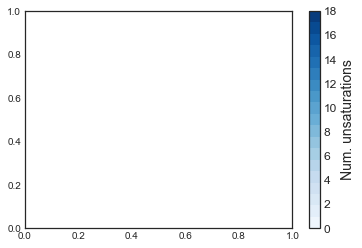

In [11]:
#### COLORBAR SANDBOX #### 
fig, ax = plt.subplots() 
sm = plt.cm.ScalarMappable(cmap=ListedColormap(unsat_palette))
sm.set_array(range(19))
unsat_cbar = fig.colorbar(sm)
unsat_cbar.ax.tick_params(labelsize=12)
# unsat_cbar.ax.yaxis.set_label_position('left')
unsat_cbar.ax.set_ylabel('Num. unsaturations', fontsize=14)

# unsat_cbar = fig.colorbar(sm)
# unsat_cbar.ax.tick_params(labelsize=12)
# unsat_cbar.ax.yaxis.set_label_position('left')
# unsat_cbar.ax.set_ylabel('Number of carbons', fontsize=14)
# plt.colorbar(lcmap)

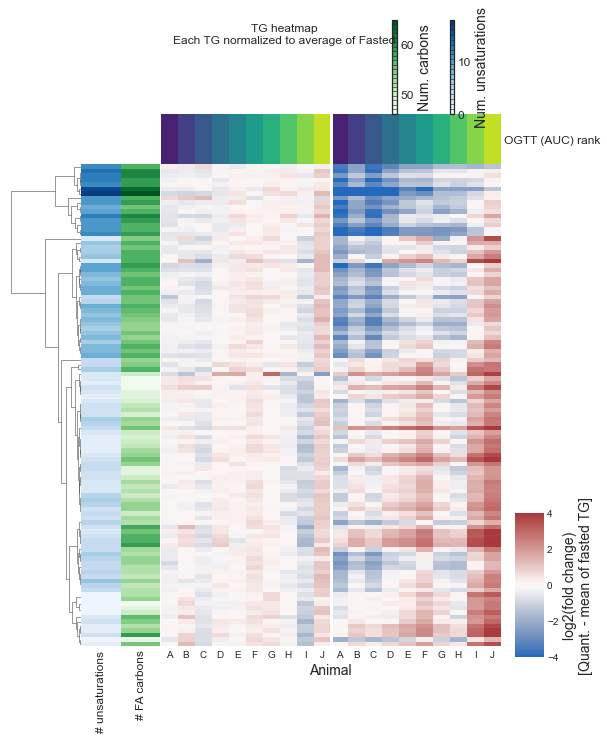

In [16]:
rbg_tg_clust = linkage(cm_data.loc[cm_data['bg_type'] == 'RBG', tgs.index].T,
                       method='complete', metric='correlation')

cm = sns.clustermap(
    data=cm_data[tgs.index].T,
    row_linkage=rbg_tg_clust, col_cluster=False, 
    row_colors=tgs[['unsat_colors', 'carbons_colors']], col_colors=cm_data[['animal_color']],
    cmap='vlag', dendrogram_ratio=0.15, colors_ratio=0.08,
#     cbar_kws=dict(label='log2(fold change)\n[Quant. - mean of fasted TG]'),
    figsize=(8, 10), cbar_pos=(0.9, 0.1, 0.05, 0.2),
    #### HEATMAP ARGUMENTS #### 
    center=0, 
    vmin=-4, vmax=4,
#     robust=True,
    xticklabels='ABCDEFGHIJ'*2, yticklabels=False,
)
cm.ax_heatmap.set_xlabel('Animal', fontsize=14)
cm.ax_heatmap.axvline(   x=10, c='white', linewidth=3)
cm.ax_col_colors.axvline(x=10, c='white', linewidth=3)


cm.ax_cbar.set_ylabel('log2(fold change)\n[Quant. - mean of fasted TG]', fontsize=14)
cm.ax_col_colors.set_yticklabels(['OGTT (AUC) rank'], fontsize=12)
cm.ax_row_colors.set_xticklabels(['# unsaturations', '# FA carbons'], fontsize=12)
# Unsaturations colorbar
sm = plt.cm.ScalarMappable(cmap=ListedColormap(unsat_palette))
sm.set_array(range(0, max_unsats+1))
unsat_cbar = fig.colorbar(sm, ax=cm.ax_col_dendrogram, orientation='vertical', drawedges=True)
unsat_cbar.ax.tick_params(labelsize=12)
# unsat_cbar.ax.yaxis.set_label_position('left')
unsat_cbar.ax.set_ylabel('Num. unsaturations', fontsize=14)

# Carbons colorbar
sm = plt.cm.ScalarMappable(cmap=ListedColormap(carbons_palette))
sm.set_array(range(min_carbons, max_carbons))
carbons_cbar = fig.colorbar(sm, ax=cm.ax_col_dendrogram, orientation='vertical', drawedges=True)
carbons_cbar.ax.tick_params(labelsize=12)
# unsat_cbar.ax.yaxis.set_label_position('left')
carbons_cbar.ax.set_ylabel('Num. carbons', fontsize=14)
cm.fig.suptitle('TG heatmap\nEach TG normalized to average of Fasted', fontsize=12)

plt.savefig('../reports/figures/all_TG_plots/TG_heatmap.svg', dpi=150, bbox_inches='tight')
plt.savefig('../reports/figures/all_TG_plots/TG_heatmap.png', dpi=150, bbox_inches='tight')

In [ ]:
cm.ax_col_colors.set_y